# <a href="https://mipt-stats.gitlab.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 7. Решающие деревья и случайные леса.


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds22_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 15 баллов
* Задача 2 &mdash; 50 баллов
* Задача 3 &mdash; 30 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set(style='whitegrid', font_scale=1.3, palette='Set2')
sns.set(font_scale=1.5)
%matplotlib inline

При решении задания используйте `sklearn`. Пропишите сюда необходимые импорты

In [27]:
import numpy as np
import pandas as pd
import scipy.stats
import warnings
import graphviz
from tqdm import tqdm_notebook

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.metrics import accuracy_score, mean_squared_error as mse, mean_absolute_percentage_error as mape, mean_absolute_error as mae
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

sns.set(font_scale=1.5)
warnings.filterwarnings("ignore")

Перед выполнением задания обязательно посмотрите <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/trees.html">ноутбук</a> с занятия по решающим деревьям.

# Аттеншн! Если не отрисовываются графы деревьев в ноутубке, см. html-версию.

---
### Задача 1.

Перед обучением линейной регрессии вы могли совершать некоторые преобразования над признаками. Какие преобразования стоит совершить перед обучением решающего дерева?

В частности, ответьте на вопрос, имеет ли смысл примененять следующие преобразования:
* монотонные функции от одного признака;
* немонотонные функции от одного признака;
* линейные функции от нескольких признаков;
* нелинейные функции от нескольких признаков;
* стандартизация признаков;
* преобразования категориальных признаков.

*Ответ:*

- Функции от нескольких признаков могут позволить уменьшить высоту решающего дерева с некоторой потерей точности (потенциально будет меньше предикатов для разделения)
- Стандартизация и монотонные функции: деревья для разделения листьев полагаются только на порядок значений признаков, применяя преобразование, которое сохраняет этот порядок, получим изоморфное дерево.
- Немонотонные функции: потенциально порядок может изменится, потеряем согласованность данных, предсказания дерева не будут адекватными.
- Преобр. категор: кажется, что в случае onehot энкодинга, что в случае введения порядка, придумывается адекватный предикат для разделения, поэтому влиять на результат это будет слабо. А вот вершин в дереве в случае onehot будет больше, обучаться будет дольше.

---
### Задача 2.

Рассмотрим данные из <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/task6.html" target="_blank">предыдущего домашнего задания</a>. Скачайте данные и разделите их на три части &mdash; обучающую, валидационную и тестовую в соотношении 3:1:1.

In [69]:
df = pd.read_csv("day.csv")
df = df.drop(columns=["instant", "dteday", "registered", "casual", "yr"])

from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337)

df = df_train

Выполните необходимые преобразования признаков

In [82]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

encoder = OneHotEncoder(drop='first', sparse=False)

def process(df, drop_temp = False, train=True):
    df = df.drop(columns=["workingday", "hum", "mnth"])
    
    if drop_temp:
        df = df.drop(columns=["temp"])
    else:
        df = df[(df['temp'] <= 0.85) & (df['temp'] >= 0.1)]
    
    df = df[(df['atemp'] <= 0.75) & (df['atemp'] >= 0.2)]
    
    df['weathergood'] = (df['weathersit'] <= 2).astype(int)
    df['season'] = -df['season'] * df['season']
    
    cats = ["weekday", "weathersit"]
    if train:
        train_cat = encoder.fit_transform(df[cats])
    else:
        train_cat = encoder.transform(df[cats])

    y = df["cnt"]
    df = df.drop(columns=['cnt'])
    
    return df, y

# X_train, y_train = shuffle(process(df), random_state=1337)
# X_test, y_test = process(df_test, train=False)
# X_valid, y_valid = process(df_valid, train=False)

In [102]:
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X, Y = shuffle(process(df, drop_temp=False), random_state=1337)
# scaler.fit(X)

cols = X.columns

# X = scaler.transform(X)
X = pd.DataFrame(X, columns=cols)


train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1 - train_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

Обучите решающее дерево глубины 3 и визуализируйте его

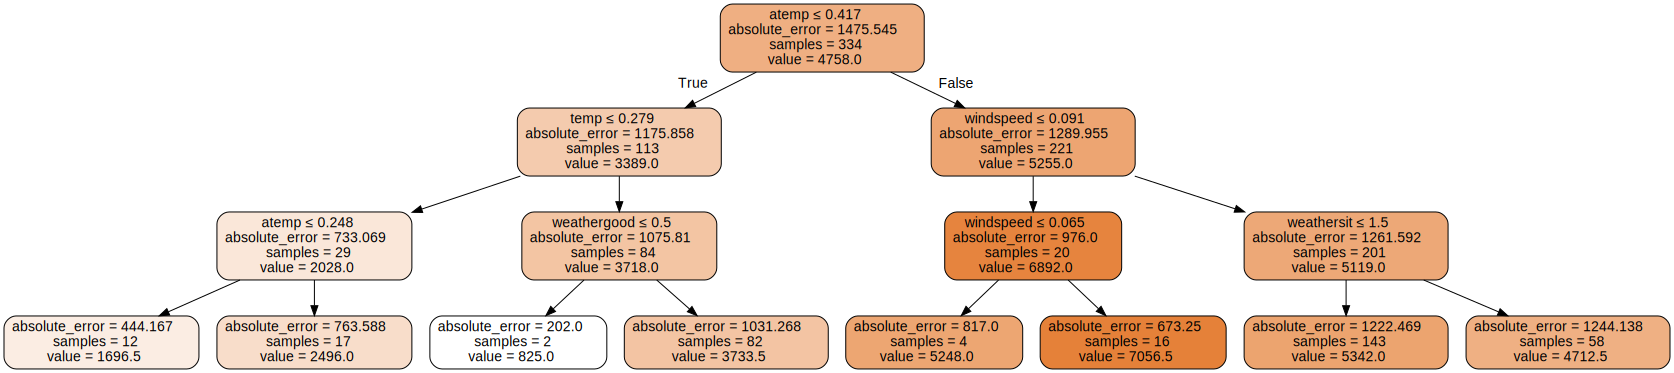

In [103]:
def get_graphviz_graph(decision_tree_regressor):
    '''
    Функция для обучения решающего дерева и построения
    по нему графа graphviz для визуализации
    '''
    
    decision_tree_regressor.fit(X_train, y_train)
    dot_data = export_graphviz(
        decision_tree_regressor, out_file=None, 
        feature_names=X_train.columns, class_names='cnt',  
        filled=True, rounded=True, special_characters=True
    )  
    return graphviz.Source(dot_data)

camera_regressor = DecisionTreeRegressor(
    criterion='absolute_error', max_depth=3
)
graph = get_graphviz_graph(camera_regressor)
graph

Подберите оптимальное значение максимальной глубины дерева. Для этого обучите решающие деревья с выставленным значением соответствующего гиперпараметра и посчитайте точность предсказаний каждого из них на валидационной выборке. Постройте соответствующий график.

In [104]:
def get_train_and_test_accuracy(param_name, grid, fixed_params = None):
        
    train_acc, test_acc = [], []
    
    for param_value in grid:
        if fixed_params is not None:
            estimator = DecisionTreeRegressor(criterion='absolute_error', **{param_name: param_value}, **fixed_params)
        else:
            estimator = DecisionTreeRegressor(criterion='absolute_error', **{param_name: param_value})
        estimator.fit(X_train, y_train)
        train_acc.append(mae(y_train, estimator.predict(X_train)))
        test_acc.append(mae(y_val, estimator.predict(X_val)))
    return train_acc, test_acc

In [96]:
def plot_dependence(param_name, grid=range(2, 20), title='', fixed_params = None, figsize=(12,6)):
    plt.figure(figsize=figsize)
    train_acc, test_acc = get_train_and_test_accuracy(param_name, grid, fixed_params)
        
    plt.plot(grid, train_acc, label='train', lw=3)
    plt.plot(grid, test_acc, label='valid', lw=3)
    plt.legend(fontsize=14)
    plt.xlabel(param_name)
    plt.ylabel('MAE')
    plt.title(title, fontsize=20)
    plt.show()
    
    return grid[np.argmin(test_acc)]

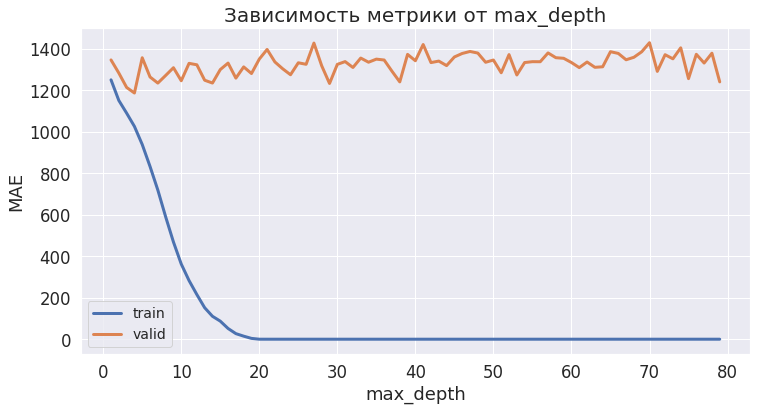

Оптимальное значение: 4


In [105]:
optim_maxd = plot_dependence(
    'max_depth', range(1, 80), 
    title='Зависимость метрики от max_depth'
)
print(f"Оптимальное значение: {optim_maxd}")

Аналогичным образом подберите минимальное число объектов в листе, зафиксировав при этом подобранное значение максимальной глубины.

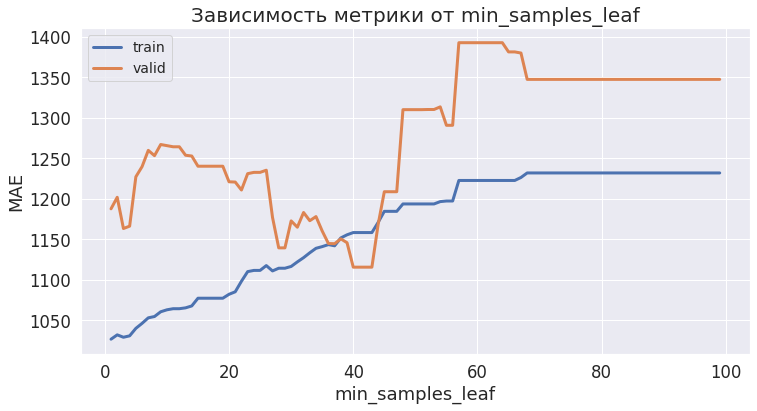

Оптимальное значение: 40


In [106]:
optim_minleaf = plot_dependence(
    'min_samples_leaf', range(1, 100),  
    title='Зависимость метрики от min_samples_leaf',
    fixed_params={"max_depth": optim_maxd}
)
print(f"Оптимальное значение: {optim_minleaf}")

Визуализируйте дерево при оптимальных гиперпараметрах и посчитайте его точность на тестовой части выборки.

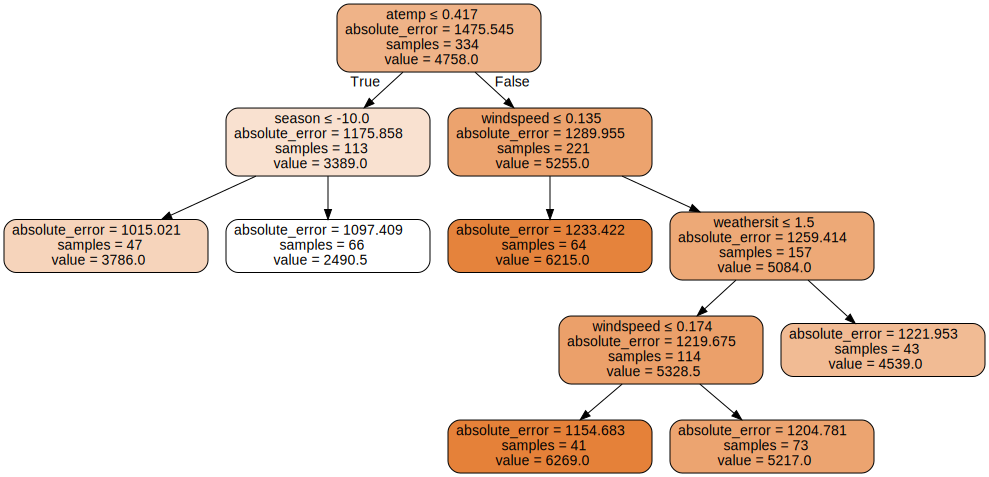

In [107]:
regressor = DecisionTreeRegressor(
    criterion='absolute_error', max_depth=optim_maxd, min_samples_leaf=optim_minleaf,
)
graph = get_graphviz_graph(regressor)
graph

In [1]:
print(f"MAE на тестовой выборке: {mae(y_test, regressor.predict(X_test))}")

MAE на тестовой выборке: 1008.9866071428571


Решающее дерево позволяет оценить *важность признаков* &mdash; некоторая величина, зависящая от того
* насколько часто тот или иной признак использовался при разбиении листа, 
* и насколько сильно при этом изменился критерий информативности.

У обученной модели значения важности признаков лежат в поле `feature_importances_`. Визуализируйте их с помощью `seaborn.barplot`.

Text(0.5, 0, 'Признак')

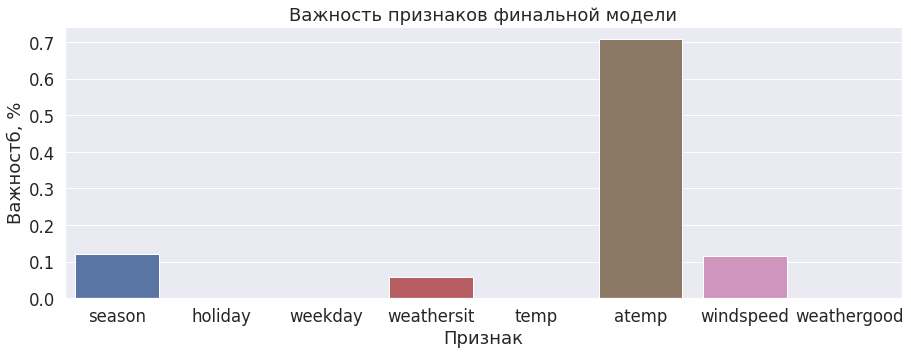

In [109]:
fig = plt.figure(figsize=(15, 5))
sns.barplot(x=X_train.columns, y=regressor.feature_importances_)
plt.title("Важность признаков финальной модели")
plt.ylabel("Важностб, %")
plt.xlabel("Признак")

Сделайте выводы:

- Деревья, как и линейные модели, обращают особое внимание на температуру и сезон, что подтверждается вполне логичной идеей зависимости таргета от метеоусловий.
- Holiday, weekday были проигнорированы. Это связано с размером дерева и корреляцией признаков с таргетом.
- при превышении определенного порога (~50-55) в гиперпараметре числа объектов в листе, значения метрики скачкообразно изменяются в худшую сторону - мы теряем листья дерева, в которых сосредоточена не самая малая доля сэмплов, ответы на которых разительно отличаются.
- Для наших данных, судя по графику, лучше всего брать глубину <= 5, больше брать смысла нет - уж очень быстро модель уходить в переобучение.
- Качество на valid ведет себя совершенно немонотонно (нет догадок, с чем связано, просто факт).

---
### Задача 3.

Для данных из предыдущей части обучите случайный лес на 500 деревьев.

In [129]:
n_estimators = 500
model = RandomForestRegressor(n_estimators=n_estimators)
model.fit(X_train, y_train)

print(f"MAE на тестовой выборке: {mae(y_test, model.predict(X_test))}")

MAE на тестовой выборке: 1061.2905535714285


Постройте график зависимости точности модели в зависимости от количества деревьев для обучающей и валидационной выборок.

*Замечание.* Не нужно заново обучать лес каждый раз. Используйте у обученной модели поле `estimators_`, это список из объектов класса `DecisionTreeRegressor`.

In [118]:
border = 1000

def get_train_and_test_accuracy(param_name, grid, fixed_params = None):
        
    train_acc, test_acc = [], []
    
    if fixed_params is not None:
        estimator = RandomForestRegressor(criterion='absolute_error', **{param_name: border}, **fixed_params)
    else:
        estimator = RandomForestRegressor(criterion='absolute_error', **{param_name: border})
        
    estimator.fit(X_train, y_train)
    dudes = estimator.estimators_.copy()
    
    for param_value in grid:
        estimator.estimators_ = dudes[:param_value]
        train_acc.append(mae(y_train, estimator.predict(X_train)))
        test_acc.append(mae(y_val, estimator.predict(X_val)))
        
    return train_acc, test_acc

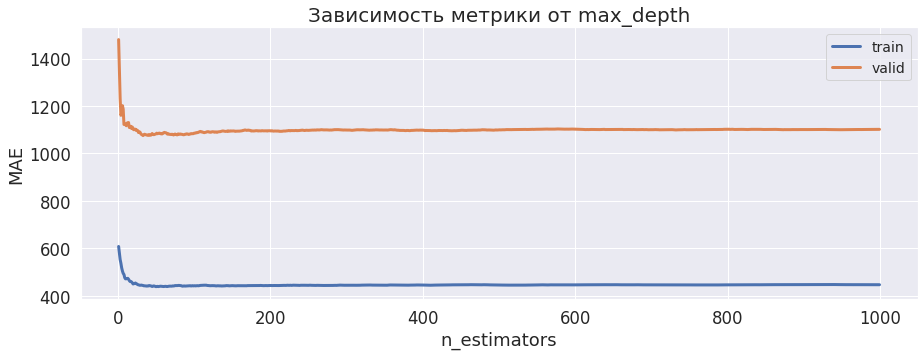

Оптимальное значение: 33


In [119]:

optim_maxd = plot_dependence(
    'n_estimators', range(1, 1000), 
    title='Зависимость метрики от max_depth',
    figsize=(15,5)
)

print(f"Оптимальное значение: {optim_maxd}")

Для леса с максимальным количеством деревьев визуализируйте
важность признаков, используя поле `feature_importances_`. 

Text(0.5, 0, 'Признак')

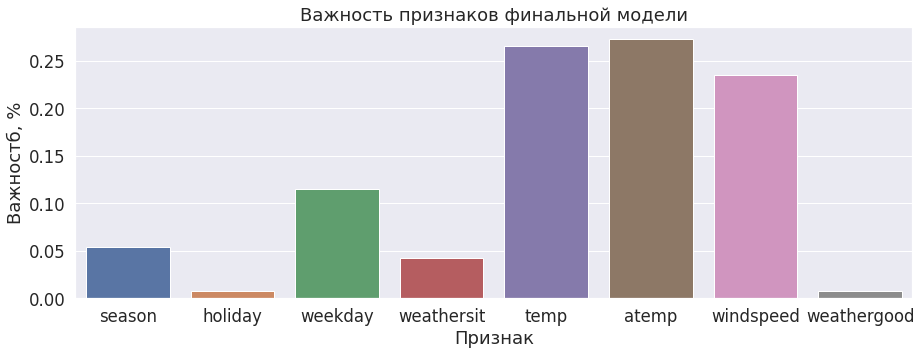

In [120]:
dudes_forest = RandomForestRegressor(criterion='absolute_error', n_estimators=optim_maxd)
dudes_forest.fit(X_train, y_train)

fig = plt.figure(figsize=(15, 5))
sns.barplot(x=X_train.columns, y=dudes_forest.feature_importances_)
plt.title("Важность признаков финальной модели")
plt.ylabel("Важностб, %")
plt.xlabel("Признак")

In [125]:
print(f"MAE на тестовой выборке: {mae(y_test, dudes_forest.predict(X_test))}")

MAE на тестовой выборке: 1086.4184253246751


- Лес несомненно учитывает больше признаков, что видно из barplot. Также увеличилась importance отдельных признаков как windspeed. Вообще говоря, такое поведение может быть полезно и давать лучшее качество на данных с большим количеством признаков, у леса будет больше степеней свободы, чем у дерева.
- При росте числа деревьев качество (неубывает?), судя по графику, не сильно колеблется. Мне кажется, тут работает некое правило усреднения при росте числа опрошенных - в случае, например, классификации, с ростом выборки доли ошибочных суждений и правильных будут выравниваться и, как в одном из примеров с лекций, опрашивая все большее число людей, будем получать все более адекватную оценку на таргет.
- Поэтому, при большом числе деревьев, они все в среднем дают один и тот же ответ, что сказывается на поведении графика ошибки - он несильно отклоняется то вверх, то вниз.
- Качество на тесте стало хуже) Но так происходит не всегда, я запускал несколько раз ноутбук, были случаи, когда лес работал лучше дерева.